In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/clothseg.zip'
extract_path = '/content/extracted_zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete!


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class ClothingSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((256, 256))(mask)
            mask = transforms.ToTensor()(mask) * 255
            mask = mask.long().squeeze(0)
            mask = torch.clamp(mask, min=0, max=NUM_CLASSES - 1)  # Ensure valid range

        return image, mask


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [ ]:
image_dir = "extracted_zip/jpeg_images/IMAGES"
mask_dir = "extracted_zip/jpeg_masks/MASKS"

full_dataset = ClothingSegmentationDataset(image_dir, mask_dir, transform=transform)

import random
from torch.utils.data import random_split

torch.manual_seed(0)
train_size = int(0.75 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4)
test_loader = DataLoader(test_set, batch_size=4)



Label Mapping


In [ ]:
label_map = {
    0: 'null', 1: 'accessories', 2: 'bag', 3: 'belt', 4: 'blazer', 5: 'blouse',
    6: 'bodysuit', 7: 'boots', 8: 'bra', 9: 'bracelet', 10: 'cape', 11: 'cardigan',
    12: 'clogs', 13: 'coat', 14: 'dress', 15: 'earrings', 16: 'flats', 17: 'glasses',
    18: 'gloves', 19: 'hair', 20: 'hat', 21: 'heels', 22: 'hoodie', 23: 'intimate', 24: 'jacket'
}
NUM_CLASSES = len(label_map)


Data Loader and Training

In [ ]:
# cuda available?
torch.cuda.is_available()

True

In [ ]:
# from torchvision.models.segmentation import FCN_ResNet50_Weights
# model = torchvision.models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
# model.classifier[4] = nn.Conv2d(512, NUM_CLASSES, kernel_size=1)

# device = torch.device("cuda")
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0005)

# def pixel_accuracy(preds, masks):
#     preds = torch.argmax(preds, dim=1)
#     correct = (preds == masks).float()
#     return correct.sum().item(), correct.numel()

# epochs = 5
# # === Training Loop ===
# for epoch in range(epochs):
#     model.train()
#     train_loss, train_correct, train_total = 0, 0, 0

#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)
#         outputs = model(images)['out']
#         loss = criterion(outputs, masks)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         correct, total = pixel_accuracy(outputs, masks)
#         train_correct += correct
#         train_total += total

#     model.eval()
#     val_loss, val_correct, val_total = 0, 0, 0
#     with torch.no_grad():
#         for images, masks in val_loader:
#             images, masks = images.to(device), masks.to(device)
#             outputs = model(images)['out']
#             loss = criterion(outputs, masks)

#             val_loss += loss.item()
#             correct, total = pixel_accuracy(outputs, masks)
#             val_correct += correct
#             val_total += total

#     print(f"Epoch {epoch+1}: Train Loss={train_loss / len(train_loader):.4f}, "
#           f"Train Acc={100 * train_correct / train_total:.2f}%, "
#           f"Val Loss={val_loss / len(val_loader):.4f}, "
#           f"Val Acc={100 * val_correct / val_total:.2f}%")


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:02<00:00, 48.7MB/s]


Epoch 1: Train Loss=0.6096, Train Acc=86.58%, Val Loss=0.4412, Val Acc=87.82%
Epoch 2: Train Loss=0.3857, Train Acc=89.14%, Val Loss=0.3850, Val Acc=89.26%
Epoch 3: Train Loss=0.3623, Train Acc=89.53%, Val Loss=0.3591, Val Acc=89.86%
Epoch 4: Train Loss=0.3381, Train Acc=90.37%, Val Loss=0.3631, Val Acc=89.51%
Epoch 5: Train Loss=0.3206, Train Acc=90.91%, Val Loss=0.3621, Val Acc=89.42%


<ipython-input-11-2dd2cdb81f91>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


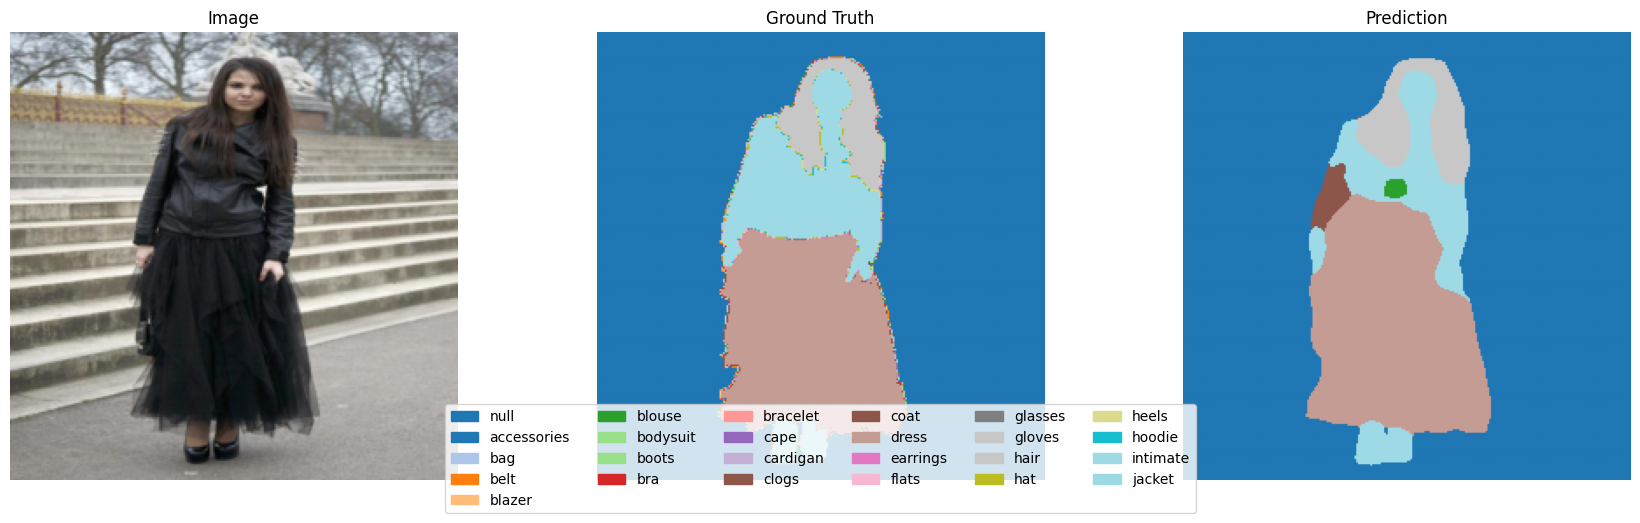

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import numpy as np

# def visualize_sample_colored(model, dataset, label_map, index=1):
#     model.eval()
#     image, mask = dataset[index]
#     mask = mask.cpu()

#     with torch.no_grad():
#         output = model(image.unsqueeze(0).to(device))
#         if isinstance(output, dict) and 'out' in output:
#             output = output['out']
#         pred = torch.argmax(output.squeeze(), dim=0).cpu()

#     # Create colormap: one color per label
#     num_classes = len(label_map)
#     cmap = plt.cm.get_cmap('tab20', num_classes)

#     # Create legend handles
#     legend_handles = [mpatches.Patch(color=cmap(i), label=label_map[i]) for i in range(num_classes)]

#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#     axs[0].imshow(image.permute(1, 2, 0))
#     axs[0].set_title("Image")
#     axs[1].imshow(mask, cmap=cmap, vmin=0, vmax=num_classes - 1)
#     axs[1].set_title("Ground Truth")
#     axs[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes - 1)
#     axs[2].set_title("Prediction")

#     for ax in axs:
#         ax.axis('off')

#     # Add legend only once below the plots
#     fig.legend(handles=legend_handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))
#     plt.tight_layout()
#     plt.show()

# visualize_sample_colored(model, full_dataset, label_map, index=1)


U NET

In [ ]:
! pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     def __init__(self, num_classes):
#         super(UNet, self).__init__()

#         def conv_block(in_ch, out_ch):
#             return nn.Sequential(
#                 nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_ch),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_ch),
#                 nn.ReLU(inplace=True),
#             )

#         self.enc1 = conv_block(3, 64)
#         self.enc2 = conv_block(64, 128)
#         self.enc3 = conv_block(128, 256)
#         self.enc4 = conv_block(256, 512)

#         self.pool = nn.MaxPool2d(2)

#         self.bottleneck = conv_block(512, 1024)

#         self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
#         self.dec4 = conv_block(1024, 512)
#         self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
#         self.dec3 = conv_block(512, 256)
#         self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
#         self.dec2 = conv_block(256, 128)
#         self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
#         self.dec1 = conv_block(128, 64)

#         self.out_conv = nn.Conv2d(64, num_classes, kernel_size=1)

#     def forward(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool(e1))
#         e3 = self.enc3(self.pool(e2))
#         e4 = self.enc4(self.pool(e3))
#         b = self.bottleneck(self.pool(e4))

#         d4 = self.up4(b)
#         d4 = self.dec4(torch.cat([d4, e4], dim=1))
#         d3 = self.up3(d4)
#         d3 = self.dec3(torch.cat([d3, e3], dim=1))
#         d2 = self.up2(d3)
#         d2 = self.dec2(torch.cat([d2, e2], dim=1))
#         d1 = self.up1(d2)
#         d1 = self.dec1(torch.cat([d1, e1], dim=1))

#         return self.out_conv(d1)


In [ ]:
import segmentation_models_pytorch as smp


def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).float()
    return correct.sum().item(), correct.numel()

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
)


device = torch.device("cuda")
model = model.to(device)

# === Training Setup ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

epochs = 30
# === Training Loop ===
for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct, total = pixel_accuracy(outputs, masks)
        train_correct += correct
        train_total += total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            correct, total = pixel_accuracy(outputs, masks)
            val_correct += correct
            val_total += total

    print(f"Epoch {epoch+1}: Train Loss={train_loss / len(train_loader):.4f}, "
          f"Train Acc={100 * train_correct / train_total:.2f}%, "
          f"Val Loss={val_loss / len(val_loader):.4f}, "
          f"Val Acc={100 * val_correct / val_total:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1: Train Loss=0.8648, Train Acc=82.92%, Val Loss=0.4725, Val Acc=88.01%
Epoch 2: Train Loss=0.4254, Train Acc=88.86%, Val Loss=0.4248, Val Acc=88.68%
Epoch 3: Train Loss=0.3833, Train Acc=89.30%, Val Loss=0.4039, Val Acc=88.94%
Epoch 4: Train Loss=0.3558, Train Acc=89.96%, Val Loss=0.3796, Val Acc=89.06%
Epoch 5: Train Loss=0.3349, Train Acc=90.43%, Val Loss=0.3649, Val Acc=89.32%
Epoch 6: Train Loss=0.3054, Train Acc=91.31%, Val Loss=0.3764, Val Acc=89.80%
Epoch 7: Train Loss=0.2854, Train Acc=92.11%, Val Loss=0.3691, Val Acc=89.71%
Epoch 8: Train Loss=0.2699, Train Acc=92.64%, Val Loss=0.3584, Val Acc=90.58%
Epoch 9: Train Loss=0.2709, Train Acc=92.71%, Val Loss=0.4256, Val Acc=87.78%
Epoch 10: Train Loss=0.2508, Train Acc=93.36%, Val Loss=0.3981, Val Acc=90.64%
Epoch 11: Train Loss=0.2329, Train Acc=93.94%, Val Loss=0.3785, Val Acc=90.38%
Epoch 12: Train Loss=0.2230, Train Acc=94.21%, Val Loss=0.4316, Val Acc=89.42%
Epoch 13: Train Loss=0.2297, Train Acc=93.94%, Val Loss=0.380

<ipython-input-10-5be2fea61ae2>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


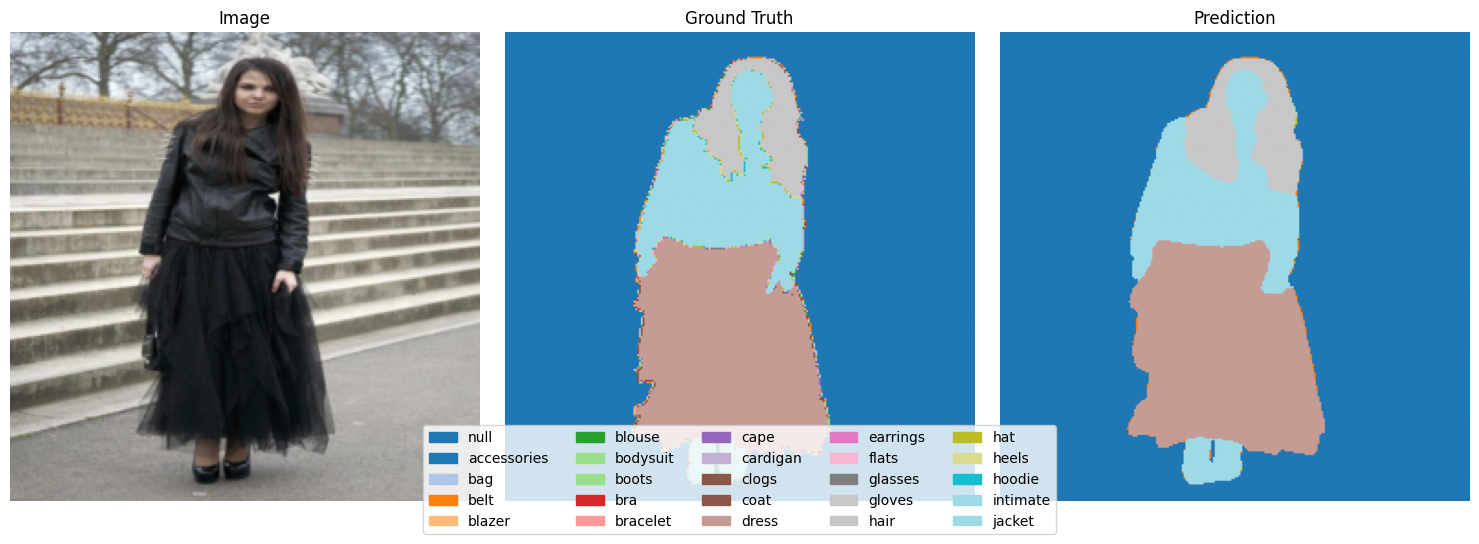

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_sample_colored(model, dataset, label_map, index=1):
    model.eval()
    image, mask = dataset[index]
    mask = mask.cpu()

    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        if isinstance(output, dict) and 'out' in output:
            output = output['out']
        pred = torch.argmax(output.squeeze(), dim=0).cpu()

    # Create colormap: one color per label
    num_classes = len(label_map)
    cmap = plt.cm.get_cmap('tab20', num_classes)

    # Create legend handles
    legend_handles = [mpatches.Patch(color=cmap(i), label=label_map[i]) for i in range(num_classes)]

    # 1 row, 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title("Image")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap=cmap, vmin=0, vmax=num_classes - 1)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes - 1)
    axs[2].set_title("Prediction")
    axs[2].axis('off')

    # Add legend below the row of plots
    fig.legend(handles=legend_handles, loc='lower center', ncol=min(5, num_classes), bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    plt.show()

visualize_sample_colored(model, full_dataset, label_map, index=1)
# 1, 8,22, 150

Problem: most regions are labeled with null, that's why we achieve high accuracy and good loss score. However, though our model could locate the person well, it generally is not good at predicting details and finer pixel-level semantics.

In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import base64
import io

# === Extraction, Overlay, and Encoding Pipeline ===

def extract_by_label(image, pred_mask, label_map, label, resize_to=None):
    """
    Extracts garment pixels from an image using a predicted mask and a label string.
    Returns:
        - cropped_rgb: garment region RGB
        - cropped_mask: binary mask
        - overlayed_rgb: original cropped with semi-transparent overlay
        - rgba_mask: transparent-style mask
        - bbox: (x0, y0, x1, y1)
    """
    # Get class ID
    inv_map = {v: k for k, v in label_map.items()}
    if label not in inv_map:
        raise ValueError(f"Label '{label}' not found.")
    class_id = inv_map[label]

    # Convert mask to binary
    if not torch.is_tensor(pred_mask):
        raise TypeError("Expected pred_mask to be torch.Tensor")
    mask_np = (pred_mask.cpu().numpy() == class_id).astype(np.uint8)

    if mask_np.sum() == 0:
        raise ValueError(f"No pixels found for label '{label}'")

    # Convert image to numpy
    if isinstance(image, Image.Image):
        image = transforms.ToTensor()(image)
    image_np = (image.cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)

    # Mask image
    masked_img = cv2.bitwise_and(image_np, image_np, mask=mask_np)

    # Crop by bounding box
    ys, xs = np.where(mask_np)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    cropped_rgb = masked_img[y0:y1+1, x0:x1+1]
    cropped_mask = mask_np[y0:y1+1, x0:x1+1]

    # Resize if needed
    if resize_to:
        h, w = resize_to
        cropped_rgb = cv2.resize(cropped_rgb, (w, h), interpolation=cv2.INTER_AREA)
        cropped_mask = cv2.resize(cropped_mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # Generate overlay
    overlay = cropped_rgb.copy()
    color = np.array([255, 0, 255])  # magenta
    alpha = 0.5
    overlay[cropped_mask > 0] = (
        (1 - alpha) * overlay[cropped_mask > 0] + alpha * color
    ).astype(np.uint8)

    # Generate RGBA transparent image
    rgba = np.zeros((cropped_mask.shape[0], cropped_mask.shape[1], 4), dtype=np.uint8)
    rgba[..., :3] = color
    rgba[..., 3] = cropped_mask * 255

    return cropped_rgb, cropped_mask, overlay, rgba, (x0, y0, x1, y1)


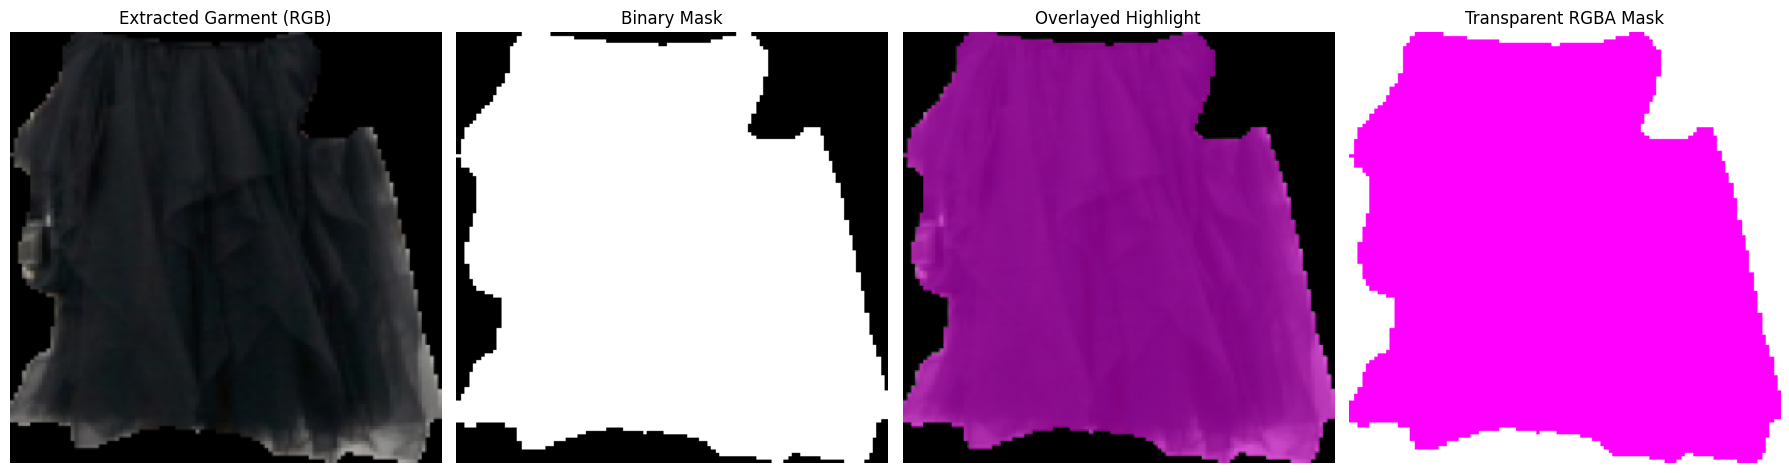

In [ ]:
idx = 1
label_to_extract = "dress"

model.eval()
image_tensor, _ = full_dataset[idx]

with torch.no_grad():
    output = model(image_tensor.unsqueeze(0).to(device))
    output = output['out'] if isinstance(output, dict) else output
    pred_mask = torch.argmax(output.squeeze(), dim=0).cpu()

# === Step 1: Extract Garment ===
rgb, mask, overlay, rgba, _ = extract_by_label(
    image=image_tensor,
    pred_mask=pred_mask,
    label_map=label_map,
    label=label_to_extract,
    resize_to=(256, 256)
)

# === Step 1 Visualization ===

fig, axs = plt.subplots(1, 4, figsize=(18, 5))

axs[0].imshow(rgb)
axs[0].set_title("Extracted Garment (RGB)")

axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Binary Mask")

axs[2].imshow(overlay)
axs[2].set_title("Overlayed Highlight")

axs[3].imshow(rgba)
axs[3].set_title("Transparent RGBA Mask")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


Visual Tryon

<ipython-input-10-5be2fea61ae2>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


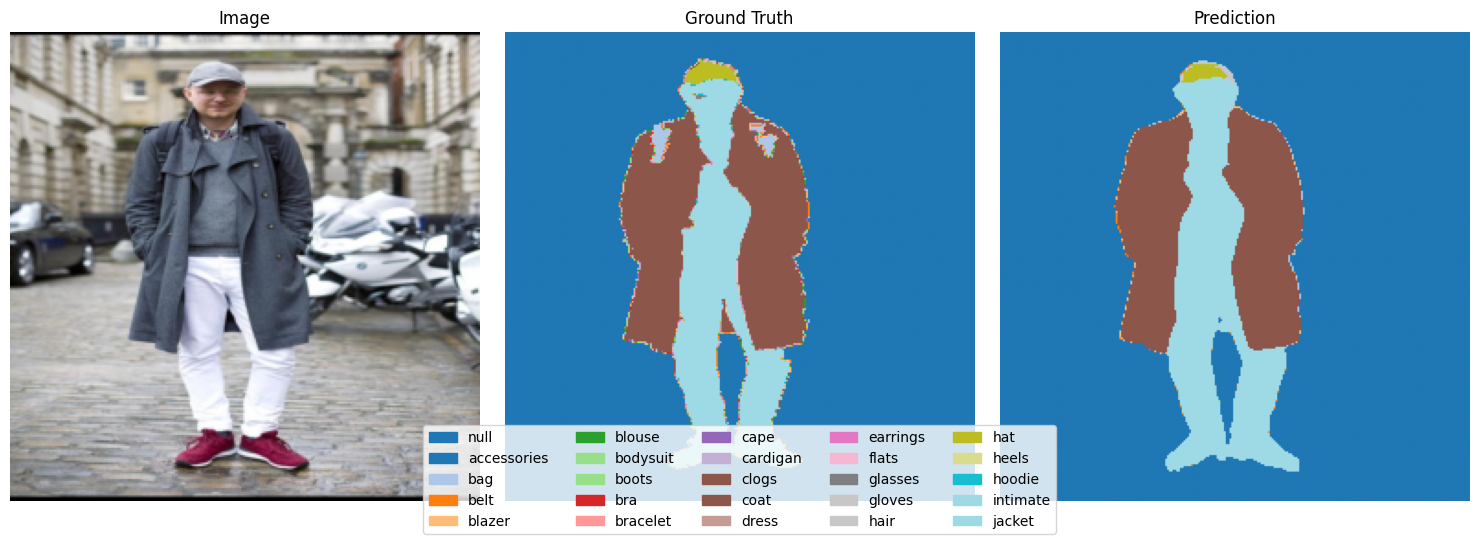

In [ ]:
# person_image = Image.open("personpic.jpg")


# person_tensor = transform(person_image).unsqueeze(0).to(device)
# with torch.no_grad():
#     output = model(person_tensor)
#     person_seg = torch.argmax(output.squeeze(), dim=0).cpu()

visualize_sample_colored(model, full_dataset, label_map, index=3)

# coat: index = 8, 2
#


In [ ]:
def extract_garment(image, mask, target_class, return_mask_only=False):
    try:
        target_class = int(target_class)
    except Exception as e:
        raise TypeError(f"[ERROR] target_class must be int, got {target_class} ({type(target_class)}). {e}")

    if not isinstance(mask, torch.Tensor):
        raise TypeError(f"[ERROR] Expected mask to be a torch.Tensor, got {type(mask)}")
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"[ERROR] Expected image to be a torch.Tensor, got {type(image)}")

    mask = mask.long()
    image = image.float()

    binary_mask = (mask == target_class)
    pixel_count = binary_mask.sum().item()
    print(f"[extract_garment] Class {target_class} → {pixel_count} pixels found")

    if return_mask_only:
        return binary_mask.cpu().numpy().astype(np.uint8)

    try:
        garment_mask = binary_mask.cpu().numpy().astype(np.uint8)
        garment = image.cpu().permute(1, 2, 0).numpy() * garment_mask[..., None]
    except Exception as e:
        raise RuntimeError(f"[extract_garment ERROR] Failed masking: {e}")

    return garment, garment_mask

import cv2
def warp_image(src_img, src_mask, target_mask):
    # Compute transformation matrix using keypoints or centroids
    src_pts = np.column_stack(np.where(src_mask > 0))
    tgt_pts = np.column_stack(np.where(target_mask > 0))
    src_pts = np.float32(src_pts[:100])
    tgt_pts = np.float32(tgt_pts[:100])

    tps = cv2.createThinPlateSplineShapeTransformer()
    matches = [cv2.DMatch(i, i, 0) for i in range(len(src_pts))]
    tps.estimateTransformation(np.array([src_pts]), np.array([tgt_pts]), matches)

    warped = tps.warpImage(src_img)
    return warped

def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.image_filenames[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    if self.transform:
        image = self.transform(image)
    else:
        image = transforms.ToTensor()(image)

    # Ensure mask is always processed properly
    mask = transforms.Resize((256, 256))(mask)
    mask = transforms.ToTensor()(mask) * 255
    mask = mask.long().squeeze(0)
    mask = torch.clamp(mask, min=0, max=NUM_CLASSES - 1)

    return image, mask

def debug_prediction_visual(model, dataset, idx, class_id):
    img, _ = dataset[idx]
    with torch.no_grad():
        pred = torch.argmax(model(img.unsqueeze(0).to(device)).squeeze(), dim=0).cpu()

    # Overlay class mask
    mask = (pred == class_id).numpy()
    img_np = img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original (idx={idx})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.imshow(mask, alpha=0.5, cmap='plasma')
    plt.title(f"Predicted class {class_id} overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def overlay_garment(person_img, warped_cloth, warped_mask):
    blended = person_img.copy()
    blended[warped_mask > 0] = warped_cloth[warped_mask > 0]
    return blended

def apply_garment_to_target_blend(garment, target_img, target_mask, alpha=0.9):
    target_np = target_img.permute(1, 2, 0).cpu().numpy()
    target_np = target_np.astype(np.float32)
    if target_np.max() > 1.0:
        target_np /= 255.0

    garment = garment.astype(np.float32)
    if garment.max() > 1.0:
        garment /= 255.0

    # Target region bbox
    tgt_yx = np.argwhere(target_mask > 0)
    if len(tgt_yx) == 0:
        print("Target mask is empty — skipping blend")
        return (target_np * 255).astype(np.uint8)

    tgt_y_min, tgt_x_min = tgt_yx.min(0)
    tgt_y_max, tgt_x_max = tgt_yx.max(0)
    tgt_h, tgt_w = tgt_y_max - tgt_y_min + 1, tgt_x_max - tgt_x_min + 1
    tgt_center = ((tgt_y_min + tgt_y_max) // 2, (tgt_x_min + tgt_x_max) // 2)

    # Garment bbox
    g_yx = np.argwhere(np.any(garment > 0, axis=2))
    g_y_min, g_x_min = g_yx.min(0)
    g_y_max, g_x_max = g_yx.max(0)
    g_h, g_w = g_y_max - g_y_min + 1, g_x_max - g_x_min + 1
    garment_cropped = garment[g_y_min:g_y_max+1, g_x_min:g_x_max+1]

    # Resize garment based on scale
    h_scale = tgt_h / g_h
    w_scale = tgt_w / g_w
    scale_factor = min(h_scale, w_scale) * 1.1

    new_h = int(g_h * scale_factor)
    new_w = int(g_w * scale_factor)
    resized_garment = cv2.resize(garment_cropped, (new_w, new_h))

    # Place centered
    top = max(tgt_center[0] - new_h // 2, 0)
    left = max(tgt_center[1] - new_w // 2, 0)
    bottom = min(top + new_h, target_np.shape[0])
    right = min(left + new_w, target_np.shape[1])

    resized_garment = resized_garment[:bottom - top, :right - left]

    garment_canvas = np.zeros_like(target_np)
    mask_canvas = np.zeros(target_mask.shape, dtype=bool)
    garment_canvas[top:bottom, left:right] = resized_garment
    mask_canvas[top:bottom, left:right] = np.any(resized_garment > 0, axis=2)

    # === Step 1: darken or alpha-out original target region ===
    for c in range(3):
        target_np[..., c][target_mask > 0] = (
            (1 - alpha) * target_np[..., c][target_mask > 0]
        )

    # === Step 2: overlay opaque garment ===
    blended = target_np.copy()
    for c in range(3):
        blended[..., c][mask_canvas] = garment_canvas[..., c][mask_canvas]

    return (blended * 255).astype(np.uint8)

def tryon_demo(model, dataset, source_idx=23, target_idx=70, class_id=20):
    print(f"[tryon_demo] Extracting garment class {class_id} from image {source_idx} onto target {target_idx}")

    model.eval()
    src_img, _ = dataset[source_idx]
    tgt_img, _ = dataset[target_idx]

    with torch.no_grad():
        src_output = model(src_img.unsqueeze(0).to(device))
        src_pred = torch.argmax(src_output.squeeze(), dim=0).cpu()

        tgt_output = model(tgt_img.unsqueeze(0).to(device))
        tgt_pred = torch.argmax(tgt_output.squeeze(), dim=0).cpu()

    # Count pixels 0 → no prediction. If it's <50, probably noise.
    src_mask_area = (src_pred == class_id).sum().item()
    tgt_mask_area = (tgt_pred == class_id).sum().item()
    print(f" Extracted {src_mask_area} pixels from SOURCE")
    print(f" Extracted {tgt_mask_area} pixels from TARGET")

    garment, _ = extract_garment(src_img, src_pred, class_id)
    _, tgt_mask = extract_garment(tgt_img, tgt_pred, class_id)
    _, src_gt = dataset[source_idx]

    garment, _ = extract_garment(src_img, src_pred, class_id)
    tgt_mask = extract_garment(tgt_img, tgt_pred, class_id, return_mask_only=True)

    # Apply garment to target
    #tryon_result = apply_garment_to_target(garment, tgt_img, tgt_mask) #v1
   #  tryon_result = apply_garment_to_target_blend(garment, tgt_img, tgt_mask) v2
    tryon_result = apply_garment_to_target_blend(
    garment=garment,
    target_img=tgt_img,
    target_mask=tgt_mask
)



    # Plot result


  #   fig, axs = plt.subplots(1, 4, figsize=(15, 5))
  #   #plt.figure(figsize=(6, 6))
  #   plt.imshow(tryon_result)
  #   plt.title("🪄 Virtual Try-On Result")
  #  # plt.axis("off")
  #   #plt.show()
  #   axs[0].imshow(garment)
  #   axs[0].set_title("Extracted Garment")
  #   axs[1].imshow(tgt_img.permute(1, 2, 0).cpu())
  #   axs[1].set_title("Target Person")
  #   axs[2].imshow(tgt_mask)
  #   axs[2].set_title("Target Region")
  #   for ax in axs:
  #       ax.axis('off')
  #   plt.tight_layout()
  #   plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Row 1
    axs[0, 0].imshow(garment)
    axs[0, 0].set_title("Extracted Garment")
    axs[0, 1].imshow(tgt_img.permute(1, 2, 0).cpu())
    axs[0, 1].set_title("Target Person")

# Row 2
    axs[1, 0].imshow(tgt_mask)
    axs[1, 0].set_title("Target Region")
    axs[1, 1].imshow(tryon_result)
    axs[1, 1].set_title("Virtual Try-On Result")

# Turn off axis for all
    for row in axs:
        for ax in row:
            ax.axis('off')

    plt.tight_layout()
    plt.show()




[tryon_demo] Extracting garment class 13 from image 3 onto target 8
 Extracted 7888 pixels from SOURCE
 Extracted 5586 pixels from TARGET
[extract_garment] Class 13 → 7888 pixels found
[extract_garment] Class 13 → 5586 pixels found
[extract_garment] Class 13 → 7888 pixels found
[extract_garment] Class 13 → 5586 pixels found


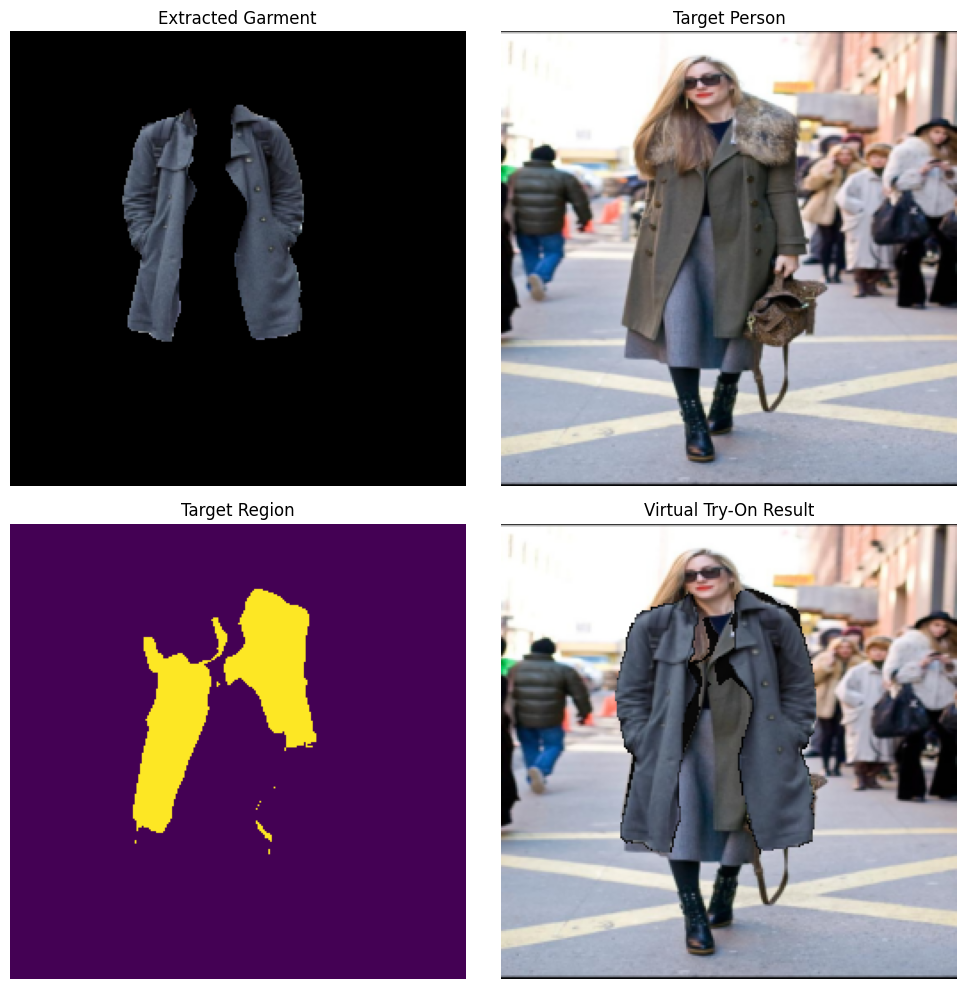

In [ ]:
tryon_demo(model, full_dataset, source_idx=3, target_idx=8, class_id=13)
# coat = 13